In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,884 cases (7 day average) as of Tue 27 Apr, -32.4 since Mon 26 Apr
107 hospitalised (7 day average) as of Wed 28 Apr, +0.0 since Wed 28 Apr
11 died (7 day average) as of Tue 27 Apr, -1.1 since Mon 26 Apr


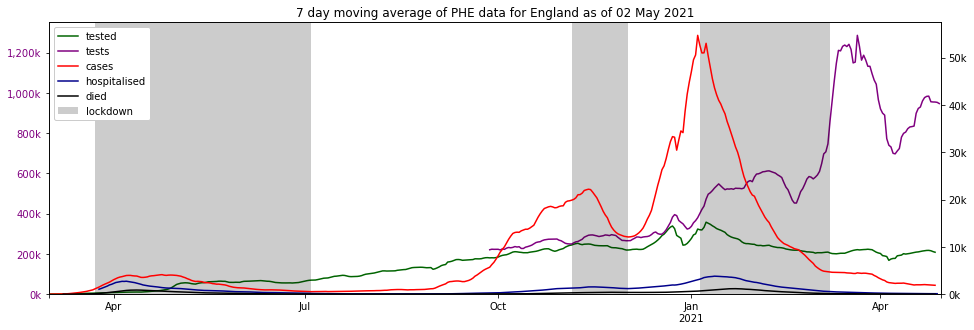

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

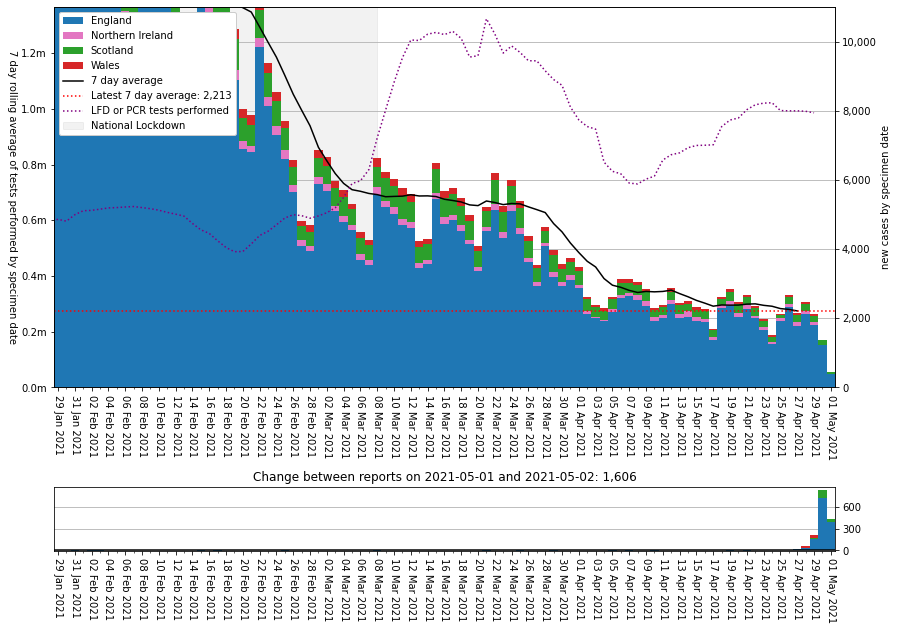

In [4]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

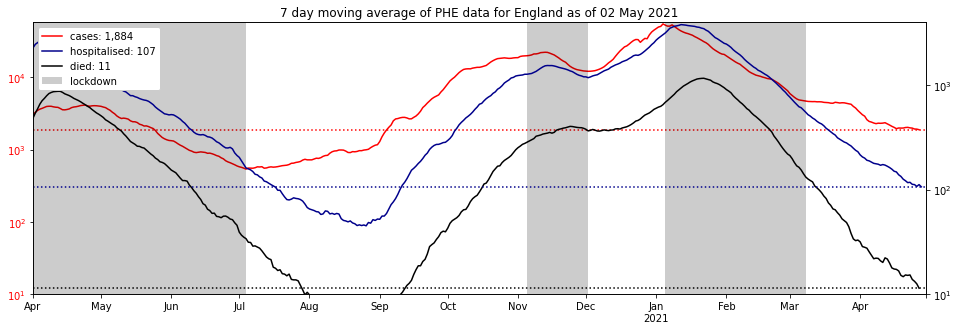

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

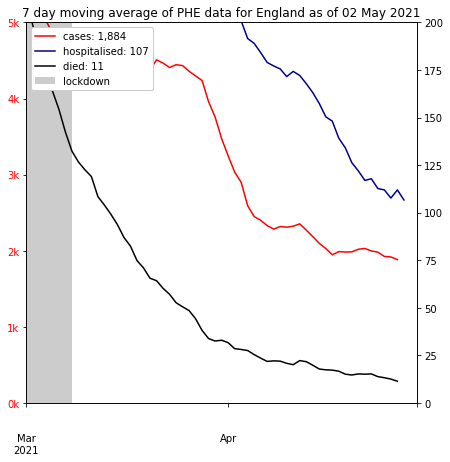

In [6]:
plot_summary(earliest_date='2021-03-01', show_latest=True, figsize=(7, 7),
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=5_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,12835358.0,28895159.0,16059801.0,56286961,22.803430,28.532009,48.664560
1,Northern Ireland,N92000002,426876.0,937782.0,510906.0,1893667,22.542295,26.979717,50.477988
2,Scotland,S92000003,1297664.0,2817752.0,1520088.0,5463300,23.752384,27.823623,48.423993
3,Wales,W92000004,769719.0,1854687.0,1084968.0,3152879,24.413211,34.411977,41.174812


'partial: 34,505,380 (51.7%), full: 15,329,617'

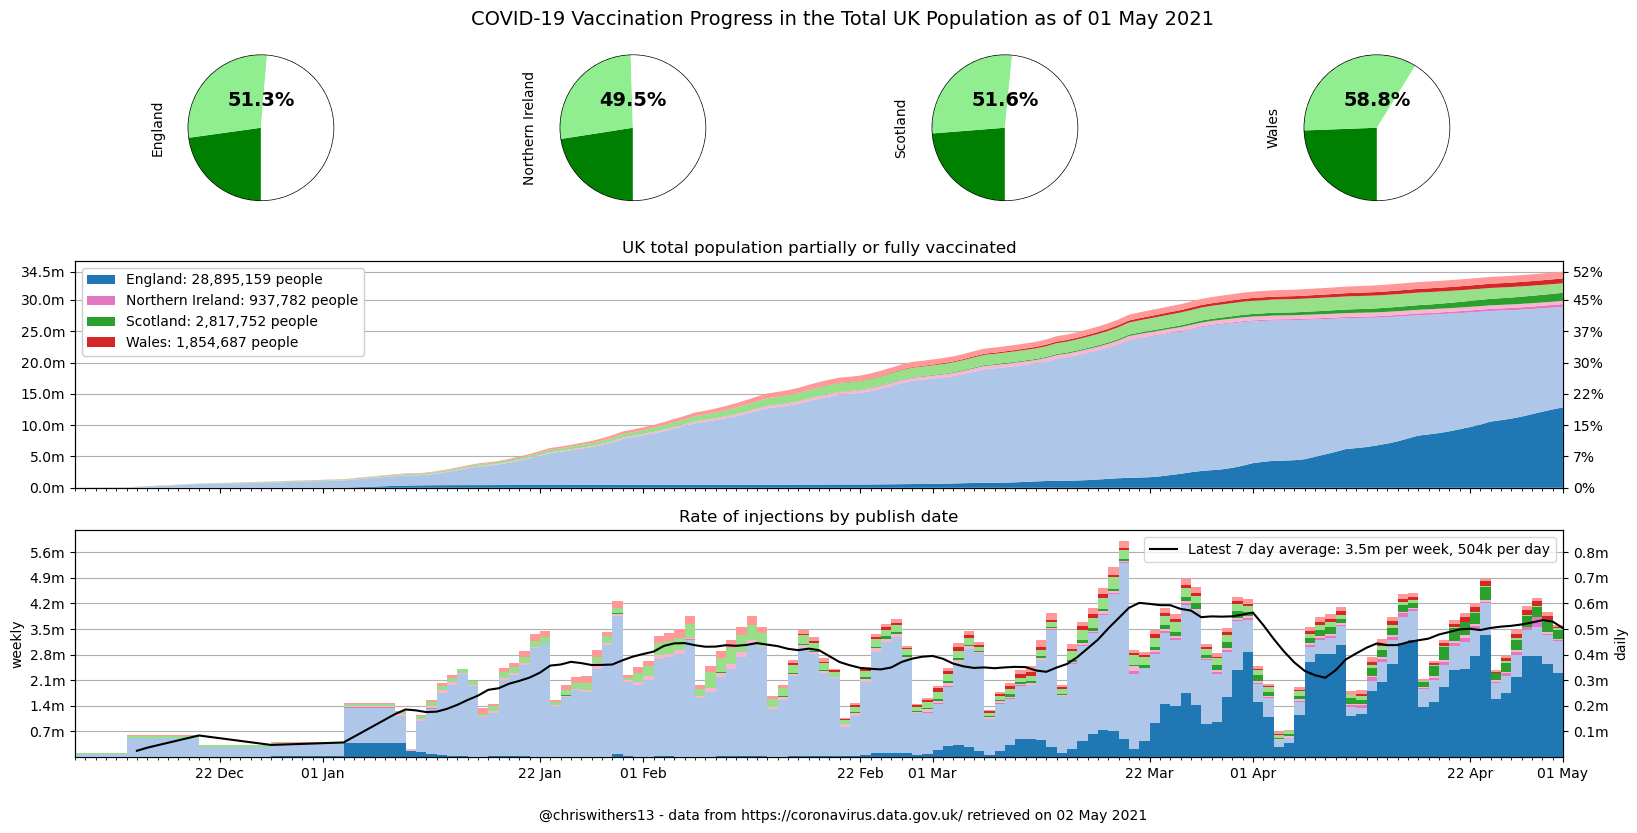

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

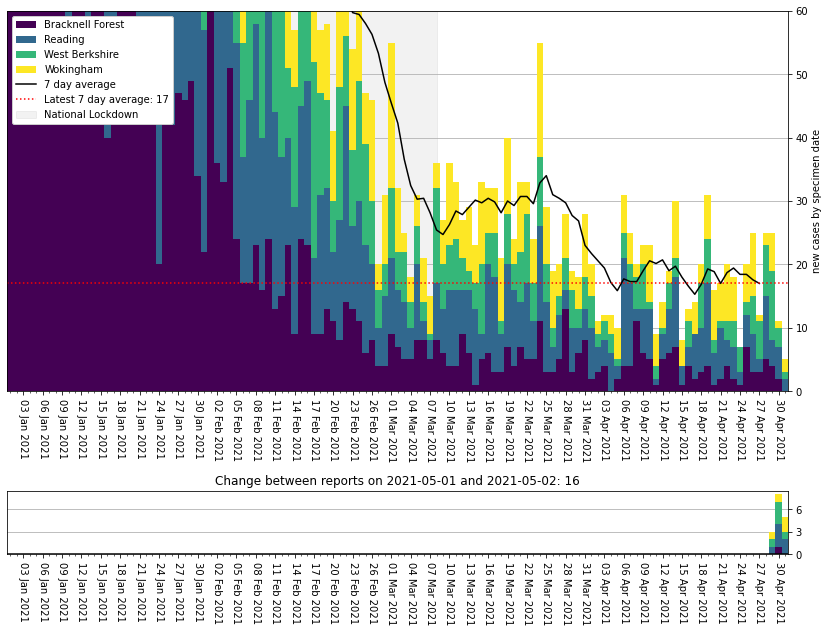

In [9]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=60)

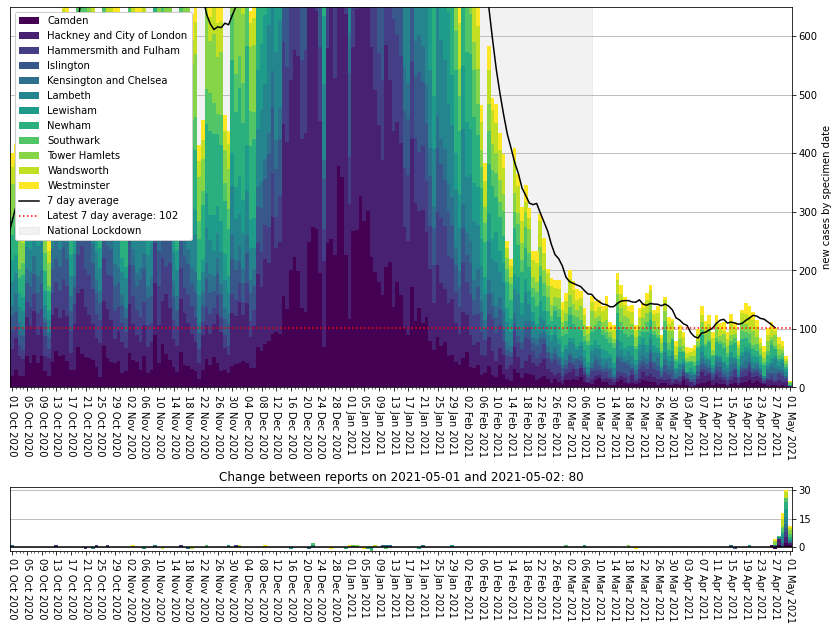

In [10]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000120,Hyndburn,128.326938,104.0,2021-05-01
S12000020,Moray,73.053642,70.0,2021-05-01
E08000001,Bolton,68.162059,196.0,2021-05-01
E06000013,North Lincolnshire,66.747150,115.0,2021-05-01
N09000005,Derry City and Strabane,65.439835,99.0,2021-05-01
E07000169,Selby,61.796513,56.0,2021-05-01
E08000016,Barnsley,58.736318,145.0,2021-05-01
E08000017,Doncaster,58.353907,182.0,2021-05-01
E08000036,Wakefield,57.706883,201.0,2021-05-01


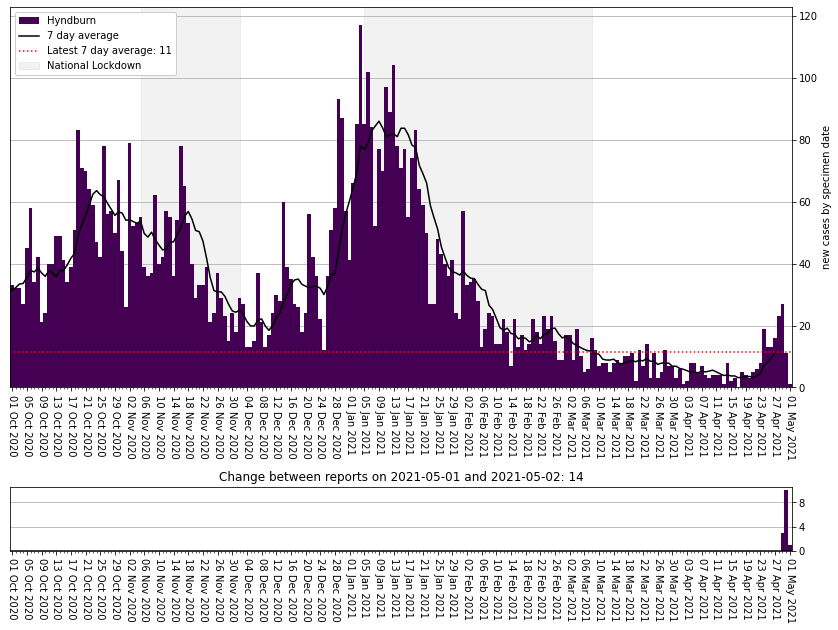

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,40.724261,323.0,2021-05-01
E08000019,Sheffield,41.890868,245.0,2021-05-01
E08000032,Bradford,43.907102,237.0,2021-05-01
E08000034,Kirklees,50.251599,221.0,2021-05-01
E08000036,Wakefield,57.706883,201.0,2021-05-01
E08000001,Bolton,68.162059,196.0,2021-05-01
E08000025,Birmingham,16.027101,183.0,2021-05-01
E08000017,Doncaster,58.353907,182.0,2021-05-01
E08000003,Manchester,31.834576,176.0,2021-05-01


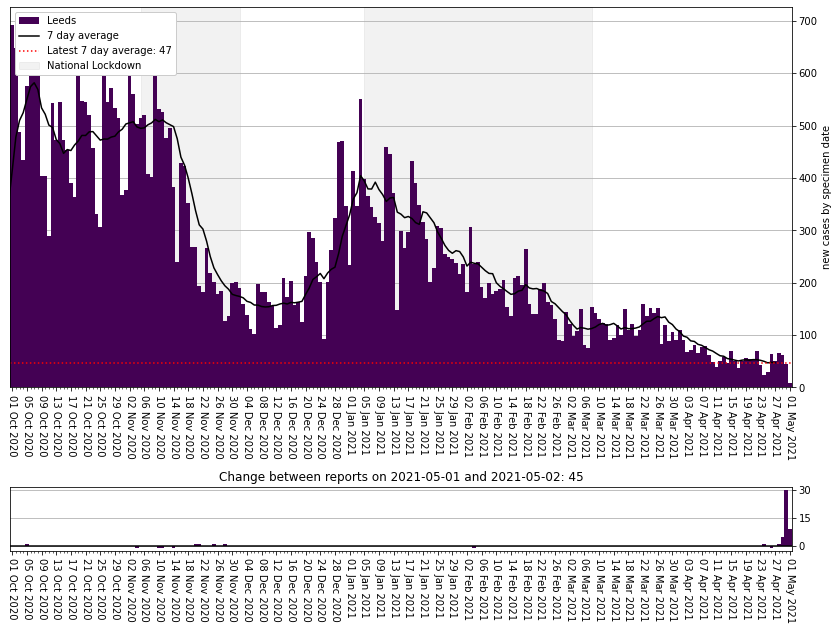

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.7
phe_max = 0.13

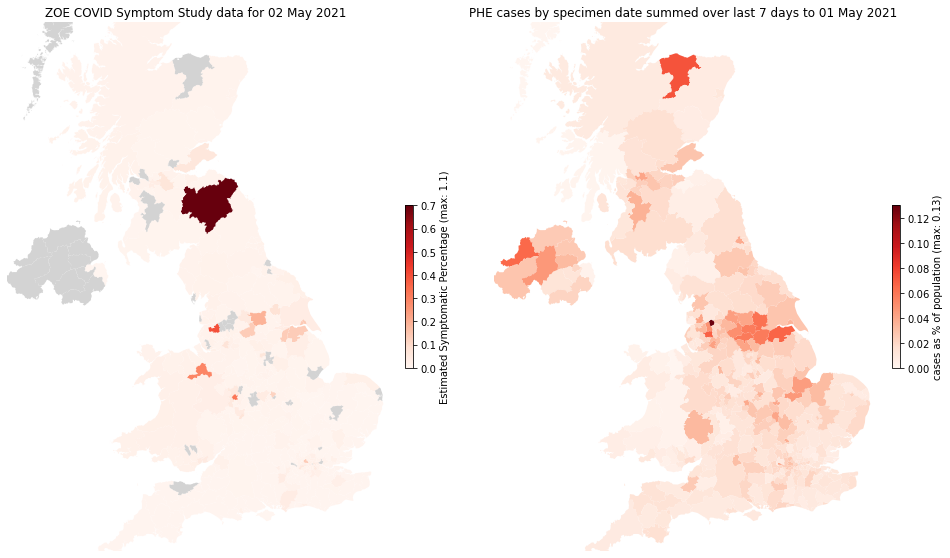

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...